In [1]:
#Plot of confirmed Corona cases in selected countries.
#Last update: 2020-03-21, 11:00, JL

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sta
import scipy.optimize
import statsmodels.stats.api as sms

#https://github.com/CSSEGISandData/COVID-19
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
fn_confirmed='time_series_19-covid-Confirmed.csv'
fn_deaths='time_series_19-covid-Deaths.csv'
fn_recovered='time_series_19-covid-Recovered.csv'
fn_population='https://raw.githubusercontent.com/datasets/population/master/data/population.csv'

In [2]:
# get John's Hopkins data and consolidate for countries.
def getJHUdata(fn,valName='cases'):
    df = pd.read_csv(fn,index_col=None)
    df=df.drop(['Lat','Long'],axis=1)
    df=df.set_index([*df.columns[:2]])
    df=df.stack().reset_index()
    df.columns=['state','country','date',valName]
    df.date=pd.to_datetime(df.date)
    df=df.groupby(['country','date']).sum().reset_index()
    return df

In [3]:
dfc = getJHUdata(url+fn_confirmed)
dfc.tail()

,country,date,cases
10426,Zimbabwe,2020-03-18,0
10427,Zimbabwe,2020-03-19,0
10428,Zimbabwe,2020-03-20,1
10429,Zimbabwe,2020-03-21,3
10430,Zimbabwe,2020-03-22,3


In [4]:
dfd = getJHUdata(url+fn_deaths,'deaths')
dfd.tail()

,country,date,deaths
10426,Zimbabwe,2020-03-18,0
10427,Zimbabwe,2020-03-19,0
10428,Zimbabwe,2020-03-20,0
10429,Zimbabwe,2020-03-21,0
10430,Zimbabwe,2020-03-22,0


In [5]:
dfr = getJHUdata(url+fn_recovered,'recovered')
dfr.tail()

,country,date,recovered
10426,Zimbabwe,2020-03-18,0
10427,Zimbabwe,2020-03-19,0
10428,Zimbabwe,2020-03-20,0
10429,Zimbabwe,2020-03-21,0
10430,Zimbabwe,2020-03-22,0


In [6]:
# get population data.
# Note, many country names don't match between population and case data.
dfp = pd.read_csv(fn_population)
dfp=dfp[dfp.Year==dfp.Year.max()]
dfp.columns=[*dfp.columns[:-1],'population']
dfp.head()

,Country Name,Country Code,Year,population
56,Arab World,ARB,2016,4.064527e+08
113,Caribbean small states,CSS,2016,7.245472e+06
170,Central Europe and the Baltics,CEB,2016,1.029741e+08
227,Early-demographic dividend,EAR,2016,3.170542e+09
284,East Asia & Pacific,EAS,2016,2.296786e+09


In [7]:
df=dfc.merge(dfd,on=[*dfc.columns[:2]])
df=df.merge(dfr,on=[*dfc.columns[:2]])
df=df.merge(dfp[[dfp.columns[0],'population']],how='left',left_on='country',right_on=dfp.columns[0])
df=df.drop('Country Name',axis=1)
df['date'] = pd.to_datetime(df['date']).dt.date
df.head()

,country,date,cases,deaths,recovered,population
0,Afghanistan,2020-01-22,0,0,0,34656032.0
1,Afghanistan,2020-01-23,0,0,0,34656032.0
2,Afghanistan,2020-01-24,0,0,0,34656032.0
3,Afghanistan,2020-01-25,0,0,0,34656032.0
4,Afghanistan,2020-01-26,0,0,0,34656032.0


In [8]:
# Compute ratios
df['cdRatio']=df.deaths/df.cases
df['casePerPop']=df.cases/df.population
df['activeCases']=df.cases-df.deaths-df.recovered
df['crRatio']=df.recovered/df.cases

df['newCases']=df.groupby(['country']).diff().cases

In [9]:
# Show all country names in the case data
allCountries=sorted(df.country.unique())
for a,b,c in zip(allCountries[::3],allCountries[1::3],allCountries[2::3]):
    print('{:<30}{:<30}{:<}'.format(a,b,c))

Afghanistan                   Albania                       Algeria
Andorra                       Angola                        Antigua and Barbuda
Argentina                     Armenia                       Australia
Austria                       Azerbaijan                    Bahamas, The
Bahrain                       Bangladesh                    Barbados
Belarus                       Belgium                       Benin
Bhutan                        Bolivia                       Bosnia and Herzegovina
Brazil                        Brunei                        Bulgaria
Burkina Faso                  Cabo Verde                    Cambodia
Cameroon                      Canada                        Cape Verde
Central African Republic      Chad                          Chile
China                         Colombia                      Congo (Brazzaville)
Congo (Kinshasa)              Costa Rica                    Cote d'Ivoire
Croatia                       Cruise Ship                   Cu

In [10]:
# Select countries for plots.
plotCountries=['Germany','Italy','Spain','Iran','Portugal', 'Korea, South','US','China']
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')

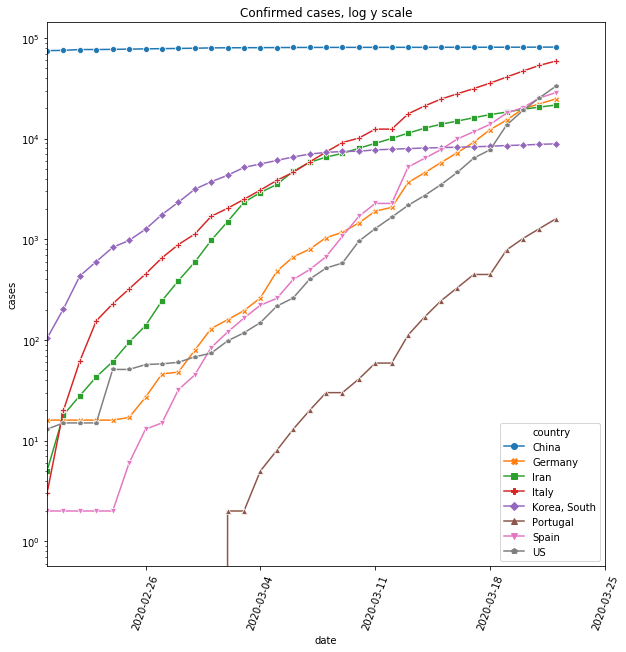

In [11]:
# Plot cases on log y scale
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)
ax = g.axes
ax.set_yscale('log')
plt.title('Confirmed cases, log y scale')
plt.xlim(left=plotStartDate)
plt.xticks(rotation=70);

Note similar slopes of european countries. Italy took of earlier

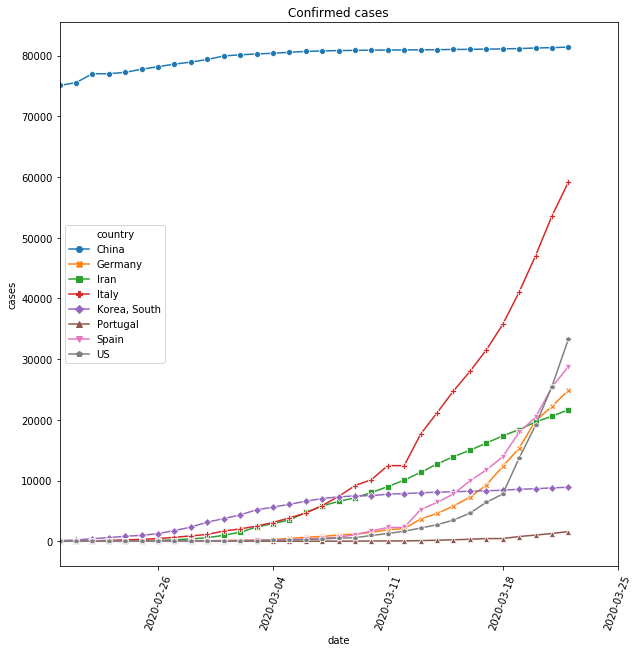

In [12]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.title('Confirmed cases');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

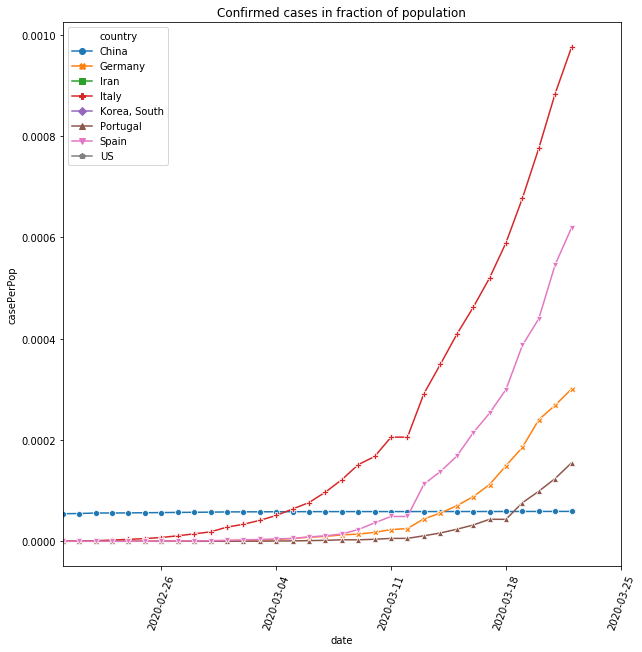

In [13]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='casePerPop',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.title('Confirmed cases in fraction of population');
plt.xticks(rotation=70);
plt.xlim(left=plotStartDate);

# New cases over time: Have any countries flattened the curve?
inspired by a NYT article -
https://www.nytimes.com/interactive/2020/03/19/world/coronavirus-flatten-the-curve-countries.html

Singapore, Taiwan, Japan, Thailand slowed the onset of exponential growth. South Korea and China managed to reduce new cases greatly.

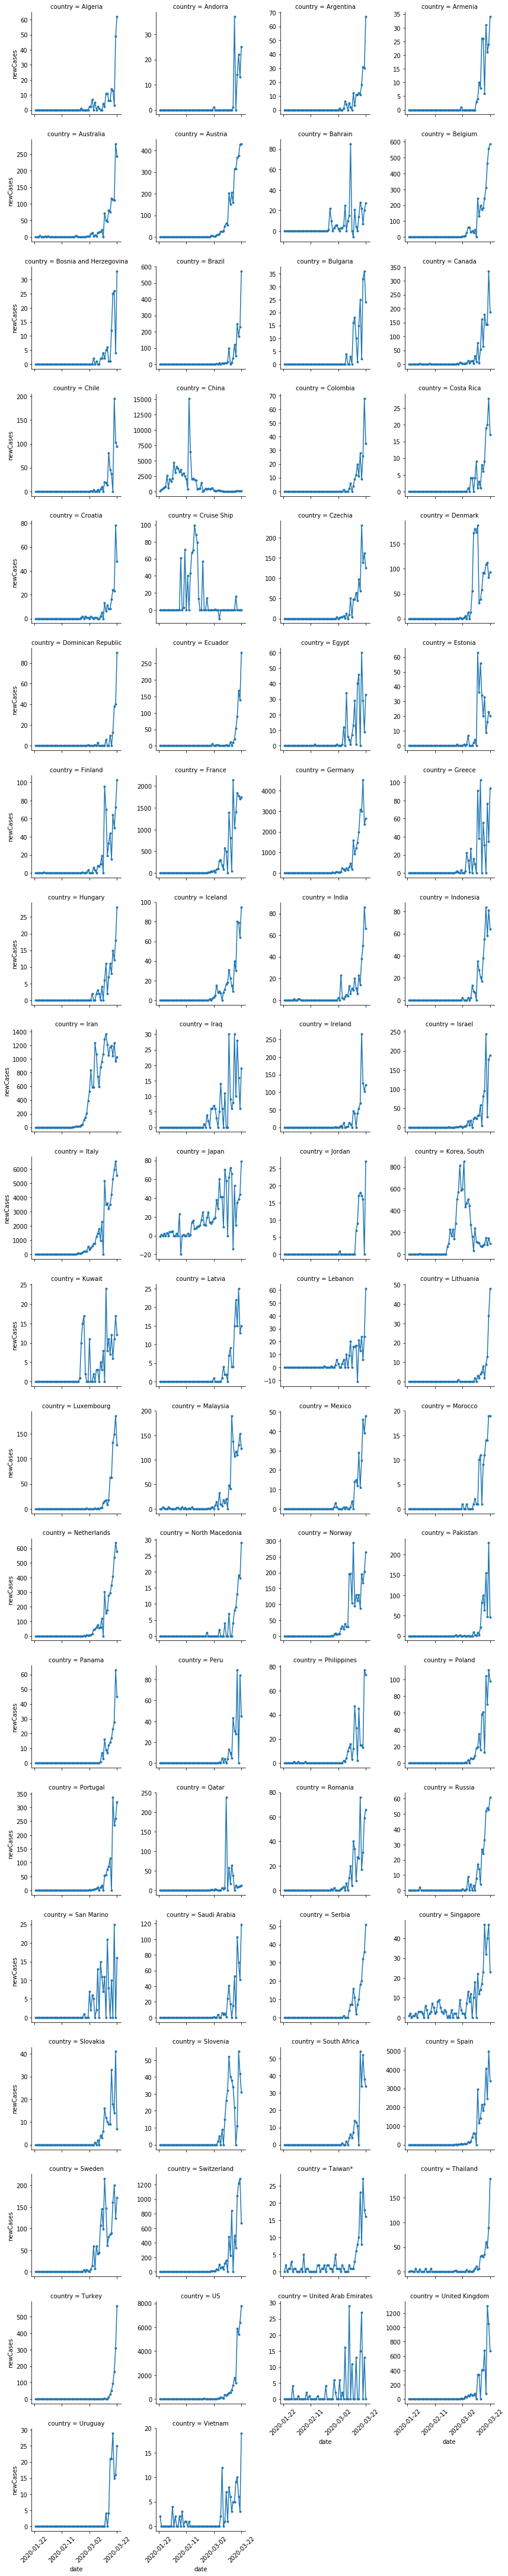

In [14]:
HighCountries=df[df.cases>100].country.unique()
ix=df.country.isin(HighCountries)

g = sns.FacetGrid(df[ix], col="country",  palette="tab20c",
                     col_wrap=4, height=3,sharey=False)

g.map(plt.plot, "date", "newCases",marker='.')

g.set(xticks=df.date.unique()[::20], xticklabels=df.date.unique()[::20])
g.set_xticklabels(rotation=45);



In [15]:
# Show latest data for Germany
ix=df.country.isin(['Germany'])
df.loc[ix][-3:]

,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases
3901,Germany,2020-03-20,19848,67,180,82667685.0,0.003376,0.000240,19601,0.009069,4528.0
3902,Germany,2020-03-21,22213,84,233,82667685.0,0.003782,0.000269,21896,0.010489,2365.0
3903,Germany,2020-03-22,24873,94,266,82667685.0,0.003779,0.000301,24513,0.010694,2660.0


In [16]:
# Show latest data for US

ix=df.country.isin(['US'])
df.loc[ix][-3:]

,country,date,cases,deaths,recovered,population,cdRatio,casePerPop,activeCases,crRatio,newCases
9818,US,2020-03-20,19100,244,0,NaN,0.012775,NaN,18856,0.0,5423.0
9819,US,2020-03-21,25489,307,0,NaN,0.012044,NaN,25182,0.0,6389.0
9820,US,2020-03-22,33272,417,0,NaN,0.012533,NaN,32855,0.0,7783.0


# Plot cases aligned to date of crossing 100 cases

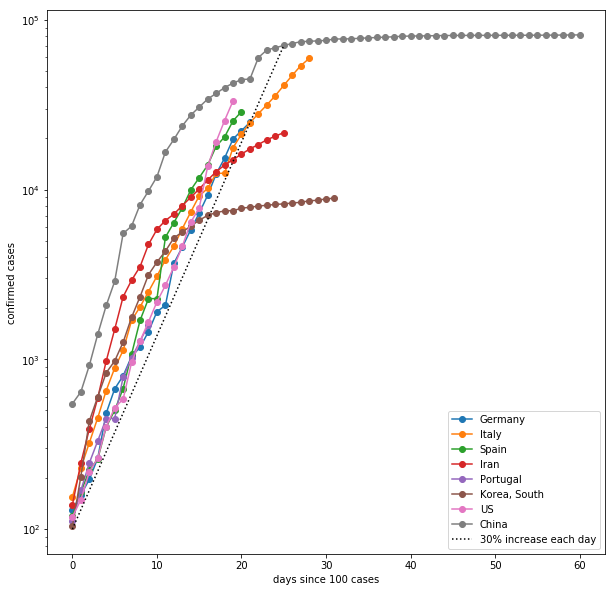

In [17]:
fix,ax=plt.subplots(figsize=(10,10))


for i,c in enumerate(plotCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        inflect=np.argmax(ts>100)
        ax.plot(ts[inflect:],'o-',label=c)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend()
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

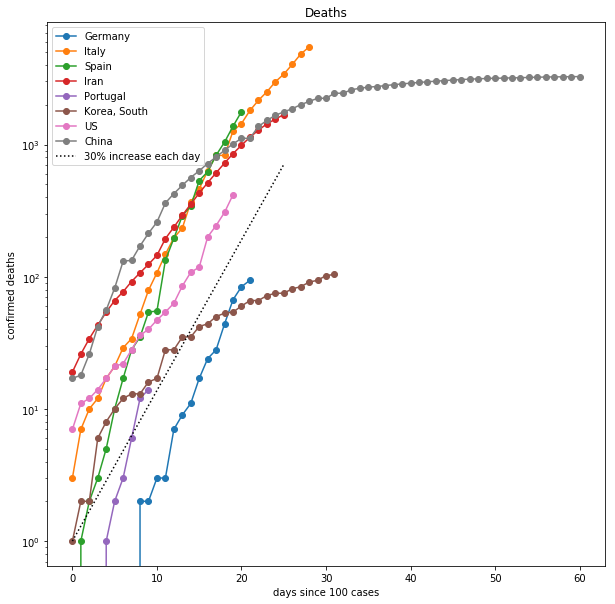

In [18]:
fix,ax=plt.subplots(figsize=(10,10))


for i,c in enumerate(plotCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        inflect=np.argmax(ts>100)
        tsDeaths=df[ix].deaths.values
        ax.plot(tsDeaths[inflect:],'o-',label=c)
    
t=np.linspace(0,25,100)
e=1*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend()
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed deaths')
plt.title('Deaths');

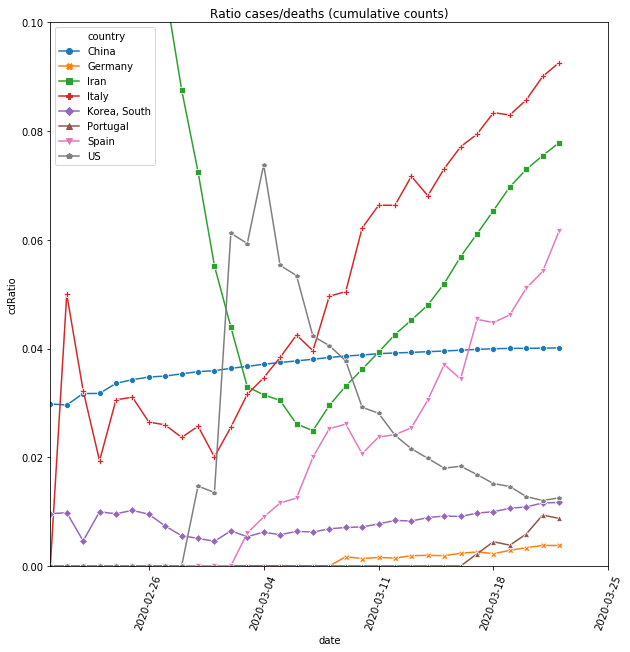

In [19]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='cdRatio',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
plt.ylim([0,.1])
plt.title('Ratio cases/deaths (cumulative counts)')
plt.xlim(left=plotStartDate);

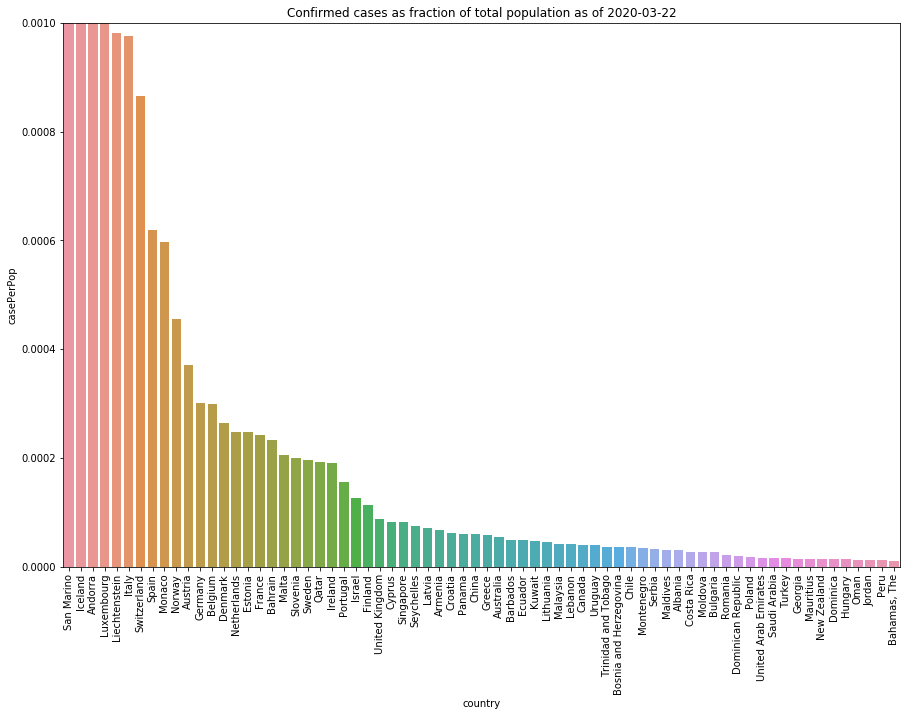

In [20]:
plt.subplots(figsize=(15,10))
ix=(df.date==df.date.max())&(df.casePerPop>0.00001)
sns.barplot(data=df[ix].sort_values(by=['casePerPop'],ascending=False),
            x='country',y='casePerPop')
plt.ylim([0,.001])
plt.title('Confirmed cases as fraction of total population as of '+str(df.date.max()))
plt.xticks(rotation=90);

#  Find % increase per day per country for recent history
## testing only countries with > 250 cases

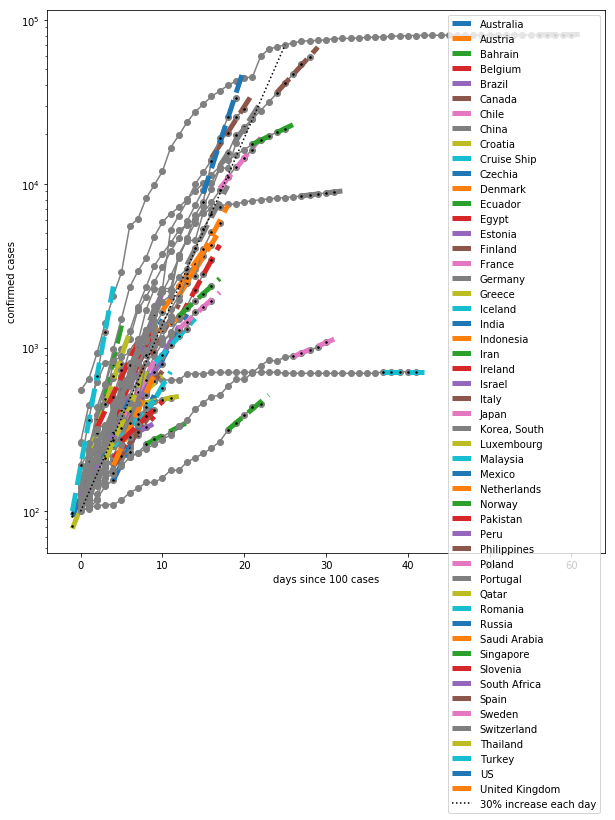

In [21]:
fitHistory=5 #days used for fit

fix,ax=plt.subplots(figsize=(10,10))

HighCountries=df[df.cases>250].country.unique()

allSlopes=np.zeros(len(HighCountries))

for i,c in enumerate(HighCountries):
    ix=df.country==c
    ts=df[ix].cases.values
    if ts[-1]>100:
        caseLen=ts.shape[0]
        inflect=np.argmax(ts>100)
        ax.plot(ts[inflect:],'o-',color='gray')
        
        x=np.arange(fitHistory)
        y=np.log10(ts[-fitHistory:])

        s,itc,r,p,std=scipy.stats.linregress(x,y)
        t=np.linspace(caseLen-fitHistory-inflect,caseLen-inflect,100)
        tx=np.linspace(0,fitHistory,100)
        l=(10**itc)*(10**(s*tx))
        allSlopes[i]=s

        ax.plot(t,l,'--',label=c,lw=5)
        ax.plot(x+caseLen-fitHistory-inflect,10**y,'k.',markersize=3)
    
t=np.linspace(0,25,100)
e=100*(1+0.3)**t
ax.plot(t,e,':k',label='30% increase each day')
ax.set_yscale('log')
plt.legend()
plt.xlabel('days since 100 cases')
plt.ylabel('confirmed cases');

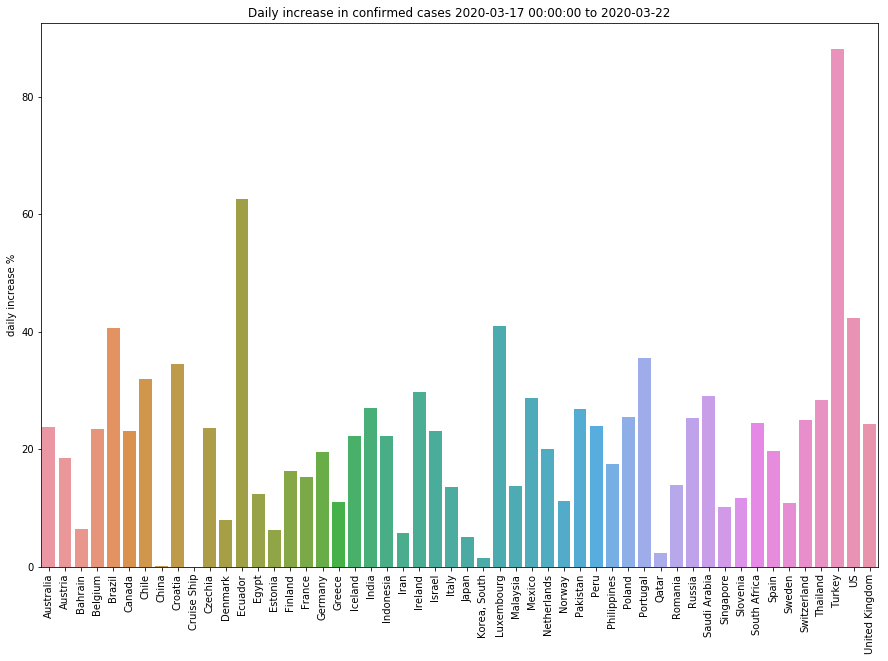

In [22]:
plt.subplots(figsize=(15,10))
sns.barplot(x=HighCountries,y=100*(10**allSlopes-1))
#plt.ylim([0,.001])
plt.title('Daily increase in confirmed cases '+str(df.date.max()-pd.DateOffset(fitHistory))+' to '+str(df.date.max()))
plt.ylabel('daily increase %')
plt.xticks(rotation=90);

# Recovery

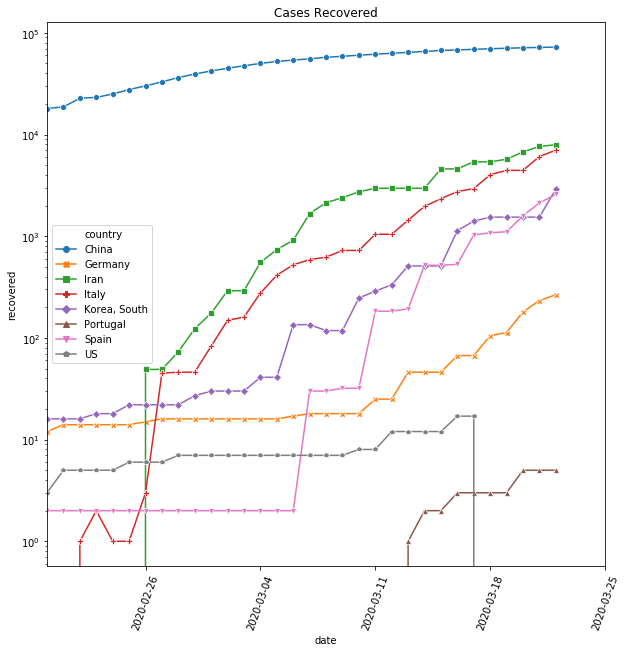

In [23]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='recovered',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Cases Recovered')
plt.xlim(left=plotStartDate);
plt.yscale('log')


# Ratio of recovered / total cases

### This ratio will eventually approach mortality, but note ~2-3 week delay from case report to recovery.

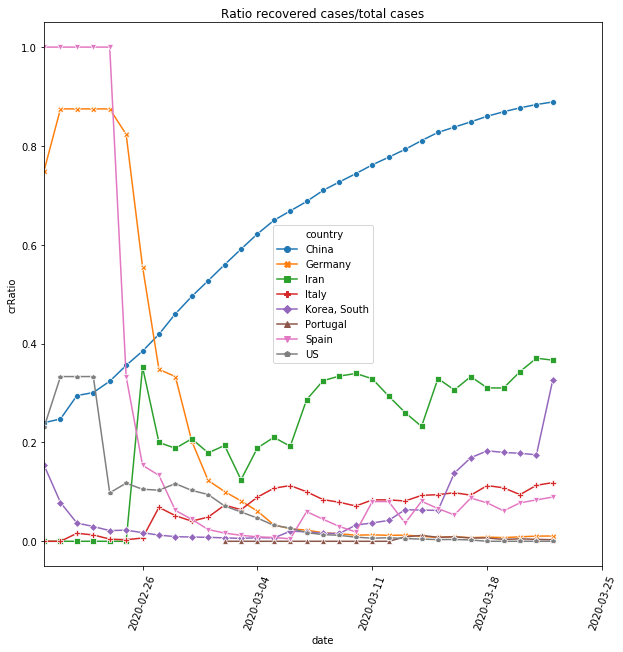

In [24]:
plt.subplots(figsize=(10,10))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='crRatio',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Ratio recovered cases/total cases')
plt.xlim(left=plotStartDate);

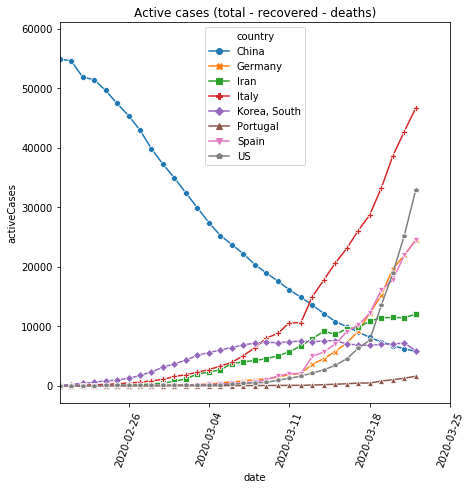

In [25]:
plt.subplots(figsize=(7,7))
ix=df.country.isin(plotCountries)
plotStartDate=pd.to_datetime('2020-02-20')
g=sns.lineplot(data=df[ix],
             x='date',
             y='activeCases',
            hue='country',
               style='country',
              dashes=False,
              markers=True)

plt.xticks(rotation=70);
#plt.ylim([0,.1])
plt.title('Active cases (total - recovered - deaths)')
plt.xlim(left=plotStartDate);